In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ruta_Test= r"C:\Users\erick\Pictures\corn\Test"
ruta_Train= r"C:\Users\erick\Pictures\corn\Train"
ruta_Val= r"C:\Users\erick\Pictures\corn\Val"

#asignamos un numero a cada sub carpeta(clases)
clases = {
    "Cercospora Leaf Spot": 0,
    "Common Rust_": 1,
    "Healthy": 2,
    "Northern Leaf Blight": 3,
} 



def cargar_rutas_y_etiquetas(ruta_base):
    rutas = []
    etiquetas = []

    for clase, etiqueta in clases.items():
        carpeta= os.path.join(ruta_base, clase)
        imgs = glob.glob(os.path.join(carpeta, "*.jpg"))  + \
            glob.glob(os.path.join(carpeta, "*.jpeg")) + \
            glob.glob(os.path.join(carpeta, "*.png"))

        for img in imgs:
            rutas.append(img)
            etiquetas.append(etiqueta)

    return rutas, etiquetas                   
        

In [5]:
#cargar carpetas y datasets

rutas_train, y_train = cargar_rutas_y_etiquetas(ruta_Train)
rutas_test, y_test = cargar_rutas_y_etiquetas(ruta_Test) 
rutas_val, y_val = cargar_rutas_y_etiquetas(ruta_Val) 

ds_train = tf.data.Dataset.from_tensor_slices((rutas_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((rutas_test, y_test))
ds_val = tf.data.Dataset.from_tensor_slices((rutas_val, y_val))


def cargar_imagen(ruta, etiqueta):
    img = tf.io.read_file(ruta)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    return img, etiqueta


ds_train = ds_train.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
ds_val= ds_val.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)


ds_train = ds_train.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)




In [66]:
# modelo de transferencia de aprendizaje tf.keras.applications.MobileNetV2


     #fue modificado para que aumente los datos
data_aumento = keras.Sequential([
    layers.RandomFlip(mode="horizontal", seed=42),
    layers.RandomRotation(factor=0.1, seed=42),
    layers.RandomContrast(factor=0.1, seed=42),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1, seed=42),
    layers.RandomBrightness(factor=0.1, seed=42),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=( 224, 224, 3),
    include_top=False, #remueve el clasificador ya fue clasificado
    weights="imagenet",
    pooling=None,
)




base_model.trainable=False #

def construir_modelo_paso2(base_model, num_clases=4):
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_aumento(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    #capas densas para mejor capacidad
    x = layers.Dense(512, activation='relu', name="dense_512")(x)
    x = layers.Dropout(0.3, name="dropout_1")(x)

    x = layers.Dense(256, activation='relu', name="dense_256")(x)
    x = layers.Dropout(0.3, name="dropout_2")(x)

    x = layers.Dense(128, activation='relu', name="dense_128")(x)
    x = layers.Dropout(0.2, name="dropout_3")(x)

    outputs = layers.Dense(num_clases, activation="softmax", name="output_layer")(x)


    model = keras.Model(inputs, outputs, name="corn_disease_classifier" )

    return model

#modelo 2

modelo_2 = construir_modelo_paso2(base_model, num_clases=len(clases))

modelo_2.summary()
modelo_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", 
            keras.metrics.SparseCategoricalAccuracy(name='acc'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
)


callbacks_2 = [
    keras.callbacks.EarlyStopping( #evitar sobreentrenamiento
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),


]

hist_2 = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val,
    callbacks=callbacks_paso2,
    verbose=1
)


#finetuning y descongelar

def fine_tuning(model, base_model, fine_tune_from=100):
    base_model.trainable = True

    for i, layer in enumerate(base_model.layers):
        if i < fine_tune_from:
            layer.trainable = False  # Mantener congeladas
        else:
            layer.trainable = True   # Descongelar para fine-tuning



    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy",
                 keras.metrics.SparseCategoricalAccuracy(name='acc'),
                 keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
    )
    return model

model_fine_tuned = hacer_fine_tuning(modelo_2, base_model, fine_tune_from=100)



callbacks_fine_tuning = [
    #Se detiene cuando el modelo deja de mejorar
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,  
        restore_best_weights=True,
        verbose=1
    ),
    # bajar taza de aprendizaje
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    #Evita perder el mejor modelo.
    keras.callbacks.ModelCheckpoint(
        filepath='modelo_fine_tuned_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


hist_fine_tuning = model_fine_tuned.fit(
    ds_train,
    epochs = 15,
    validation_data=ds_val,
    callbacks=callbacks_fine_tuning,
    verbose=1
)





Model: "corn_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_7 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_7 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,596 (11.74 MB)

 Trainable params: 820,612 (3.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8819 - loss: 0.2929
Epoch 1: val_accuracy did not improve from 0.90699
229/229 ━━━━━━━━━━━━━━━━━━━━ 172s 748ms/step - accuracy: 0.9359 - loss: 0.1732 - val_accuracy: 0.9046 - val_loss: 0.2318 - learning_rate: 2.5000e-05
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8841 - loss: 0.2832
Epoch 2: val_accuracy did not improve from 0.90699
229/229 ━━━━━━━━━━━━━━━━━━━━ 172s 749ms/step - accuracy: 0.9375 - loss: 0.1662 - val_accuracy: 0.9058 - val_loss: 0.2308 - learning_rate: 2.5000e-05
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8872 - loss: 0.2759
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 3: val_accuracy did not improve from 0.90699
229/229 ━━━━━━━━━━━━━━━━━━━━ 170s 740ms/step - accuracy: 0.9379 - loss: 0.1662 - val_accuracy: 0.9064 - val_loss: 0.2263 - learning_rate: 2.5000e-05
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - acc

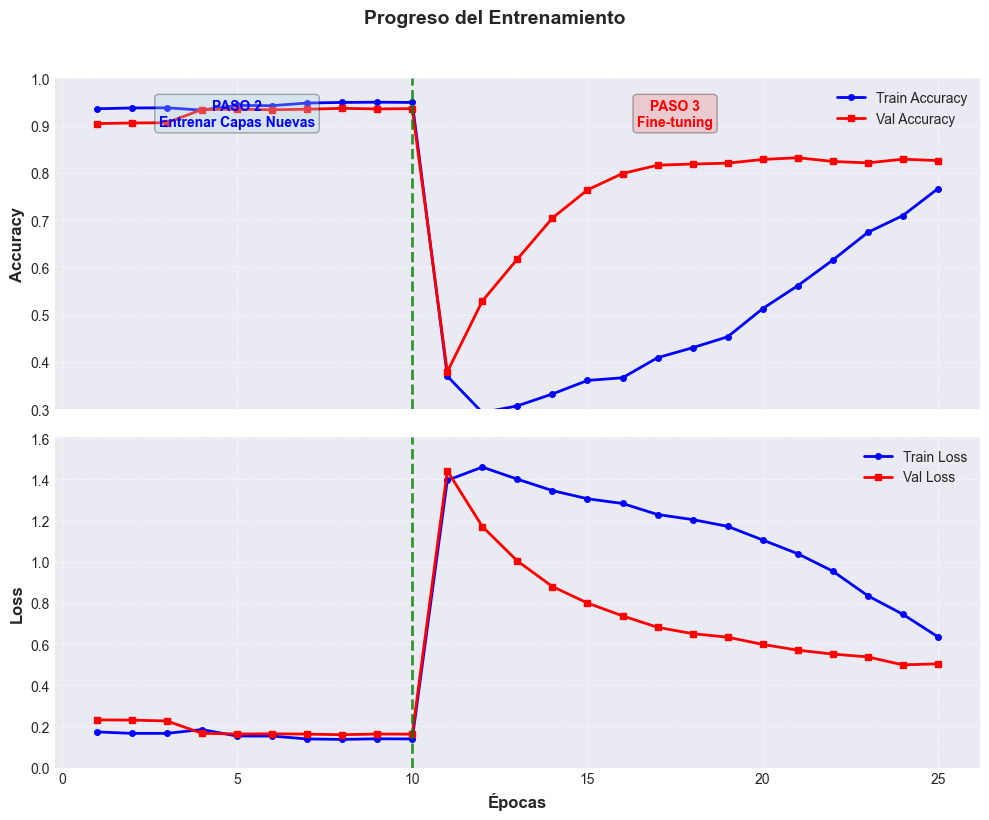

In [70]:
#grafica y resultados 

epochs_totales  = len(hist_2.history['loss']) + len(hist_fine_tuning.history['loss'])
split_point = len(hist_2.history['loss']) 


train_acc = hist_2.history["accuracy"] + hist_fine_tuning.history["accuracy"]
val_acc = hist_2.history['val_accuracy'] + hist_fine_tuning.history['val_accuracy']
train_loss = hist_2.history['loss'] + hist_fine_tuning.history['loss']
val_loss = hist_2.history['val_loss'] + hist_fine_tuning.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# accuracy
ax1.plot(epochs, train_acc, 'b-', marker='o', markersize=4, linewidth=2, label='Train Accuracy')
ax1.plot(epochs, val_acc, 'r-', marker='s', markersize=4, linewidth=2, label='Val Accuracy')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim([0.3, 1.0])  # Ajusta según tus datos
ax1.set_yticks(np.arange(0.3, 1.05, 0.1))
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)

# loss
ax2.plot(epochs, train_loss, 'b-', marker='o', markersize=4, linewidth=2, label='Train Loss')
ax2.plot(epochs, val_loss, 'r-', marker='s', markersize=4, linewidth=2, label='Val Loss')
ax2.set_xlabel('Épocas', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_ylim([0.0, max(train_loss + val_loss) * 1.1])  # Ajuste automático
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.6)


ax1.axvline(x=split_point, color='green', linestyle='--', linewidth=2, alpha=0.8)
ax2.axvline(x=split_point, color='green', linestyle='--', linewidth=2, alpha=0.8)

ax1.text(split_point/2, ax1.get_ylim()[1]*0.9, 'PASO 2\nEntrenar Capas Nuevas', 
         ha='center', fontsize=10, color='blue', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.3))

ax1.text(split_point + (len(hist_fine_tuning.history['loss'])/2), 
         ax1.get_ylim()[1]*0.9, 'PASO 3\nFine-tuning', 
         ha='center', fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.3))


plt.suptitle('Progreso del Entrenamiento', 
             fontsize=14, fontweight='bold', y=1.02)


plt.tight_layout()
plt.show()



Predicciones: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 0 3]
Etiquetas reales: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


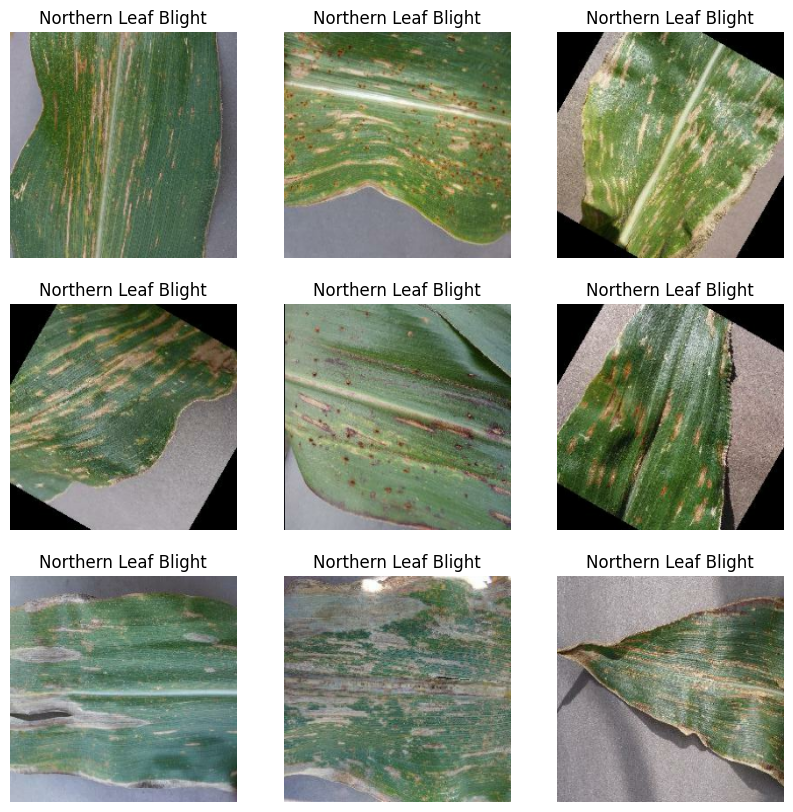

In [22]:
class_names = list(clases.keys())

image_batch, label_batch = next(iter(ds_test))
predictions = model.predict_on_batch(image_batch)

pred_labels = tf.argmax(predictions, axis=1)

print("Predicciones:", pred_labels.numpy())
print("Etiquetas reales:", label_batch.numpy())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[int(pred_labels[i])])
    plt.axis("off")
plt.show()